In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patches as patches
import os
import glob
import seaborn as sns
from scipy import stats
import statsmodels.stats.api as sms
import cv2
import gaitFunctions
from gaitFunctions import pairwiseStats
import combineClips
import plotClip
def meanstdstr(vals):
    return str(np.round(np.mean(vals),2)) + ' ± ' + str(np.round(np.std(vals),2))

In [3]:
# plot colors and parameters
axis_fontsize=11
tick_fontsize=9

# colors for step kinematics
stance_color = '#5656ff'
swing_color = '#e1e813'
duty_color = '#4d4d4d'
ipsi_color = 'tab:red'
contra_color = 'tab:green'
mcl_color = 'tab:orange'

# colors for legs
first_pair_color = '#bc272d' # red
first_pair_color_alt = '#f77276' # salmon
second_pair_color = '#50a9d4' # teal
second_pair_color_alt = '#95dafc' # sky blue
third_pair_color = '#fa9805' # orange
third_pair_color_alt = '#e9c716' # gold
rear_leg_color = '#a665c9'# violet
rear_leg_color_alt = '#0000a2' # indigo

# scatter marker size and alpha
marker_size = 10
marker_alpha = 0.7
marker_color = 'k'

# control vs. experimental colors
cmap = 'PiYG_r'

def getLevelColor(cmap,level):
    colormap = mpl.colormaps[cmap]
    level_boundaries = np.linspace(-0.95,0.95,20)
    cmap_levels = np.linspace(0,1,21)
    
    for i, boundary in enumerate(level_boundaries):
        if level <= boundary:
            return colormap(cmap_levels[i])
        
    return colormap(cmap_levels[-1])

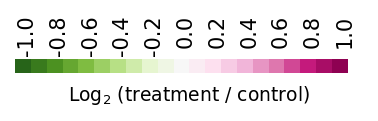

In [4]:
# horizontal map

levels = np.linspace(-1,1,21)
xlevel = 0
f,ax = plt.subplots(figsize=(3,1), dpi=150, facecolor=(1,1,1,0))
for i, level in enumerate(levels):
    square_color = getLevelColor(cmap, level)
    square = patches.Rectangle((xlevel, 0.1), 1, 1, linewidth=0.1, edgecolor=None, facecolor=square_color)        
    ax.add_patch(square)
    tenx = int(np.round(level*10,1))
    if tenx % 2 == 0:
        ax.text(xlevel+0.15,3.8,str(np.round(level,1)), rotation=90, verticalalignment='top')
    xlevel += 1
ax.set_xlabel('Log$_{2}$ (treatment / control)')
ax.set_xlim([0,len(levels)+1])
ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)
ax.spines.bottom.set_visible(False)
ax.spines.left.set_visible(False)
ax.set_aspect('equal')
ax.set_yticks([])
ax.set_xticks([])
ax.yaxis.label.set_size(tick_fontsize)
ax.xaxis.label.set_size(tick_fontsize)
ax.tick_params(axis='both', which='major', labelsize=tick_fontsize)
# ax.set_axis_off()

plt.show()

In [5]:
# load data from existing excel file
excel_filename = 'control_v_disulfiram.xlsx'
path_summaries_df = pd.read_excel(excel_filename, sheet_name='path_summaries', index_col=None)
step_timing_df = pd.read_excel(excel_filename, sheet_name='step_timing', index_col=None)
step_summaries_df = pd.read_excel(excel_filename, sheet_name='step_summaries', index_col=None)
gait_summaries_df = pd.read_excel(excel_filename, sheet_name='gait_summaries', index_col=None)
gait_styles_speeds_df = pd.read_excel(excel_filename, sheet_name='gait_speeds', index_col=None)
control = 'control'
experimental = 'disulfiram'

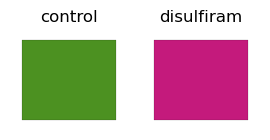

In [6]:
col_level = 0.8
con_color = getLevelColor('PiYG_r', -col_level)
exp_color = getLevelColor('PiYG_r', col_level)
palette = [con_color,exp_color]

f,[ax1,ax2] = plt.subplots(1,2,figsize=(2.8,1.5))
con_square = patches.Rectangle((0.1, 0.1), 0.8, 0.8, linewidth=0.1, edgecolor='k', facecolor=con_color)        
ax1.add_patch(con_square)
ax1.axis('off')
ax1.set_title(control)

exp_square = patches.Rectangle((0.1, 0.1), 0.8, 0.8, linewidth=0.1, edgecolor='k', facecolor=exp_color)        
ax2.add_patch(exp_square)
ax2.axis('off')
ax2.set_title(experimental)

plt.tight_layout()
plt.show()

# examine values for a column (e.g. to look for outliers)

Looking at  Body Length (mm)
full set: 67
control 33 0.26761089229351975
disulfiram 34 0.2461009768972889


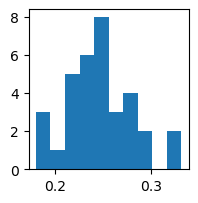

,Identifier,Body Length (mm),treatment
28,iw_16dec_tardigrade1_disulfiram,0.238510,disulfiram
19,iw_13dec_tardigrade04_disulfiram,0.239261,disulfiram
43,iw_8dec_tardigrade03_disulfiram,0.242140,disulfiram
50,iw_17apr_tardigrade01_disulfiram,0.243367,disulfiram
25,iw_13dec_tardigrade07_disulfiram,0.248456,disulfiram
11,iw_12jan_tardigrade06_disulfiram,0.249176,disulfiram
3,iw_12jan_tardigrade02_disulfiram,0.250047,disulfiram
21,iw_13dec_tardigrade05_disulfiram,0.251761,disulfiram


In [7]:
# col = 'Speed (body lengths / sec cruising)'
col = 'Body Length (mm)'
print('Looking at ', col)
df = path_summaries_df[['Identifier',col,'treatment']]
print('full set:', len(df))
c_vals = df[df['treatment']==control][col].values
c_mean = np.nanmean(c_vals)
print(control, len(c_vals), c_mean)
e_vals = df[df['treatment']!=control][col].values
e_mean = np.nanmean(e_vals)
print(experimental, len(e_vals), e_mean)

# show a histogram for this column
toshow_df = df[df['treatment']==experimental] # experimental or control
f = plt.figure(figsize=(2,2))
a=f.add_axes([0.1,0.1,0.8,0.8])
plt.hist(toshow_df[col].values)
plt.show()

# show a bit of dataframe around halfway point to find 'average' individual
halfpoint = int(len(toshow_df)/2)
buffer = 4
toshow_df.sort_values(by=col).head(halfpoint+buffer).tail(2*buffer) # .head(half + some).tail(some)

In [ ]:
treatments = [experimental,control]
for t in treatments:
    vals = df[df['treatment']==t][col].values
    print('max', t, np.max(vals))
    print('mean', t, np.mean(vals))
    print('min', t, np.min(vals))
    print('n',t,'=', len(vals))
    print()

# Selecting data to analyze

In [ ]:
# Path Data
print(path_summaries_df.columns)
path_cols =[
#     'Body Size (mm^2)', 
    'Body Length (mm)',
#     'Body Width (mm)', 
    'Body Width/Length Ratio', 
#     'Duration analyzed (sec)',
#     'Distance traveled (mm)', 
    'Percentage of time cruising', # this is basically body length / sec, and inverse of stops / sec
#     'Speed (mm/sec)',
    'Speed (body lengths / sec)', 
#     'Speed (mm/sec cruising)', 
    'Speed (body lengths / sec cruising)',
#     'Total bearing change (deg)', 
#     'Bearing change (deg) / sec',
    'Bearing change (deg) / sec cruising', 
#     'Number of stops', 
#     'Stops / sec', # this is basically just the inverse of % cruising
#     'Number of turns', 
#     'Turns / sec'
]
print(len(path_cols))

In [ ]:
# STEP KINEMATICS
# print(step_summaries_df.columns) # working need to update all of these - rerun analyzeSteps and combineClips
step_cols = [
    'Stance duration (lateral legs)', 
    'Swing duration (lateral legs)',
#     'Gait cycle (lateral legs)', 
#     'Duty factor (lateral legs)',
    'mm per step (lateral legs)', 
    'bodylength per step (lateral legs)',
    'Stance duration (rear legs)', 
    'Swing duration (rear legs)',
#     'Gait cycle (rear legs)', 
#     'Duty factor (rear legs)',
#     'mm per step (rear legs)', 
    'bodylength per step (rear legs)', 
#     'Metachronal lag (lateral legs)',
#     'Metachronal lag (normalized, lateral legs)',
#     'Metachronal lag Abs (Left-Right Ratio)',
#     'Metachronal lag ratios per L3 step', # transformed this to
    'Abs MCL Ratio per L3',
#     'Bearing change per L3 step',
#     'Anterior swing offsets (lateral legs)',
    'Anterior swing offsets (normalized, lateral legs)',
#     'Opposite swing offsets (lateral legs)',
    'Opposite swing offsets (normalized, lateral legs)',
#     'Opposite swing offsets (rear legs)',
    'Opposite swing offsets (normalized, rear legs)']
print(len(step_cols))

In [ ]:
print(len(step_summaries_df))
print(len(path_summaries_df))
print(step_summaries_df['Abs MCL Ratio per L3'].values)
print(step_summaries_df['Metachronal lag Abs (Left-Right Ratio)'].values)

In [ ]:
# GAIT STYLES
# print(gait_summaries_df.columns)
gait_cols = [
#     '% stand (lateral legs)',
#     '% pentapod (lateral legs)',
    '% tetrapod canonical (lateral legs)',
#     '% tetrapod gallop (lateral legs)', 
#     '% tetrapod other (lateral legs)',
#     '% tetrapod total (lateral legs)', 
    '% tripod canonical (lateral legs)',
#     '% tripod other (lateral legs)', 
#     '% tripod total (lateral legs',
#     '% other (lateral legs)',
#     '% stand (rear legs)', 
#     '% hop (rear legs)',
    '% step (rear legs)',
    'Tetrapod Coordination Strength',
#     'Tetrapod Bout Speed (bodylength / s)',
    'Tripod Coordination Strength',
#     'Tripod Bout Speed (bodylength / s)'
#     'CLR tetrapod canonical (lateral legs)',
#     'CLR tripod canonical (lateral legs)',
#     'CLR step (rear legs)'
]
print(len(gait_cols))

# Exploring the data
What are correlations in all data? To see this, merge the dataframes
<br> ... but a problem with merging is that we OMIT anything that does not have step tracking!
<br> ... may need/want to keep these, especially if we are interest in (non-cruising) speed.

In [ ]:
def mergeDataframes(dflist,col='Identifier'):
    df = dflist[0].copy()
    for i in np.arange(len(dflist[:-1])):
        df = df.merge(dflist[i+1],on=col)
    return df

def getDfForCol(col, dflist):
    for df in dflist:
        if col in df.columns:
            return df.copy()
    return None

In [ ]:
merged_df = mergeDataframes([path_summaries_df, step_summaries_df, gait_summaries_df])
merged_df.columns

In [ ]:
df = merged_df.copy() # merged_df or path_summaries_df step_summaries_df gait_summaries_df
analysis_cols = ['treatment'] + path_cols + step_cols + gait_cols
df = df[analysis_cols]

In [ ]:
df.count()
# df.describe()

In [ ]:
# change 'treatment' to category datatype, and see how many unique values we have (there should be 2)
for df in [merged_df, path_summaries_df, step_summaries_df, gait_summaries_df]:
    df['treatment'] = df['treatment'].astype('category') 
    df['Condition'] = np.where(df['treatment'] == control, 0, 1) # dummy variable for treatment

merged_df.describe(include='category')

In [ ]:
# looking at ALL data for a specified column
col = 'Swing duration (lateral legs)'
df = getDfForCol(col, [path_summaries_df, step_summaries_df, gait_summaries_df])
f,[a1,a2,a3] = plt.subplots(1,3,figsize=(10,3))
a1=sns.histplot(ax=a1, x=df[col])
a2=sns.boxplot(ax=a2, y=df[col], showmeans=True)
a3=sns.kdeplot(ax=a3, x=df[col], fill=True, linewidth=2);
plt.tight_layout()
plt.show()

In [ ]:
# comparing control vs. treatment for a specified column (col)
f,(a1,a2) = plt.subplots(1,2,figsize=(6,3))
print(col)
df = getDfForCol(col, [path_summaries_df, step_summaries_df, gait_summaries_df])
sns.boxplot(ax=a1, x=df['treatment'], palette=palette, y=step_summaries_df[col], showmeans=True)
sns.kdeplot(ax=a2, x=col, hue='treatment', palette=palette, data=df, fill=True)
plt.tight_layout()
plt.show()

In [ ]:
# Converting to ZSCORES (ended up not going in this direction . . . )
f,(a1,a2) = plt.subplots(1,2,figsize=(6,3))
df = getDfForCol(col, [path_summaries_df, step_summaries_df, gait_summaries_df])
print(col)
conditions = df['Condition'].values
zscores = np.zeros(len(df[col].values))
control_data = df[df['Condition']==0][col].values
exp_data = df[df['Condition']==1][col].values
control_mean = np.nanmean(control_data)
control_std = np.nanstd(control_data)
exp_std = np.nanstd(exp_data)

for i, val in enumerate(df[col].values):
    if conditions[i] == 0: # control
        zscores[i] = (val-control_mean) / control_std
    elif conditions[i] == 1: # exp
        zscores[i] = (val-control_mean) / exp_std

sns.boxplot(ax=a1, x=df['treatment'], y=zscores, palette=palette, showmeans=True)
sns.kdeplot(ax=a2, x=zscores, hue='treatment', palette=palette, data=df, fill=True)
plt.tight_layout()
plt.show()

In [ ]:
# T-test using fancy statsmodels
control_data = df[df['Condition']==0][col].values
exp_data = df[df['Condition']==1][col].values
print(control, 'n =', len(control_data))
print(experimental, 'n =', len(control_data))
levene=stats.levene(control_data, exp_data)
if levene.pvalue < 0.1:
    var = 'unequal'
    print('unequal variance')
else:
    var = 'pooled'
model = sms.CompareMeans.from_data(control_data, exp_data)
print(model.summary(usevar=var))

In [ ]:
# looking for correlations within the dataset
comp_cols = path_cols+step_cols+gait_cols
df = merged_df[comp_cols]
corrmat = df.corr(numeric_only=True)
sns.heatmap(corrmat,cmap=cmap) # 'bwr' # https://matplotlib.org/stable/users/explain/colors/colormaps.html
plt.show()

# Linear Regression 

In [ ]:
# Try a linear regression with X as 'Condition' and Y as a column of interest
import statsmodels.api as sm
col = 'Swing duration (lateral legs)'
df = getDfForCol(col, [path_summaries_df, step_summaries_df, gait_summaries_df])
Y = df[col] # col is from above, or reset here
X = df['Condition'] # 
X = sm.add_constant(X)
model = sm.OLS(Y, X, missing='drop')
model_result = model.fit()
model_result.summary()

In [ ]:
# check residuals from linear regression - are they normally distributed?
fig = plt.figure(figsize=(10,3))
ax1 = fig.add_axes([0.1,0.1,0.25,0.8])
ax2 = fig.add_axes([0.4,0.1,0.2,0.8])
ax3 = fig.add_axes([0.7,0.1,0.25,0.8])

mu, std = stats.norm.fit(model_result.resid)

# plot the residuals
sns.histplot(ax=ax1, x=model_result.resid, stat="density", linewidth=0, kde=True, label = 'observed')
ax1.set(title="Distribution of residuals", xlabel="residual")

# plot corresponding normal curve
xmin, xmax = ax1.get_xlim() # the minimum and maximum x values from the histogram above
x = np.linspace(xmin, xmax, 100) # generate some x values for the normal curve
p = stats.norm.pdf(x, mu, std) # calculate the y values for the normal curve
sns.lineplot(ax=ax1, x=x, y=p, color="orange", label = 'normal')

sns.boxplot(ax=ax2, x=model_result.resid, showmeans=True)
ax2.set(title="Distribution of residuals")

sm.qqplot(model_result.resid, line='s',ax=ax3)
ax3.set(title="QQ Plot")

plt.show()

In [ ]:
f,a = plt.subplots(1,1,figsize=(3.8,3))
sm.graphics.plot_fit(model_result, 1, vlines=False, ax=a)
plt.show()

# multiple linear regression
### aka ANCOVA (analysis of covariance sez Brooks)

In [ ]:
# could do, for example, condition and speed vs. swing duration
# or condition and speed vs. swing duration
ycol = 'Swing duration (lateral legs)'
xcol = 'Speed (body lengths / sec cruising)'
Y = merged_df[ycol]
X = merged_df[['Condition', xcol]] 
X = sm.add_constant(X)
X.head(3)

In [ ]:
model = sm.OLS(Y, X)
model_res = model.fit()
model_res.summary()

In [ ]:
f,a = plt.subplots(1,1,figsize=(3.8,3))
sm.graphics.plot_fit(model_res,1, vlines=False, ax=a)
plt.show()

# Functions for pairwise boxplots and stats

In [ ]:
def compViolPlot(ax,df,col,pcolors,vwidth=0.8,scatter=True,medsize=5):
    
    # rearrange groupnames so 'control' is first
    groupnames = sorted(np.unique(df.treatment.values))
    if 'control' in groupnames:
        ind = groupnames.index('control')
        control = groupnames.pop(ind)
        groupnames.insert(0, control)
    
    # collect data
    data_to_plot = []
    for i,group in enumerate(groupnames):
        thisdata = df[df.treatment == group][col].values
        thisdata = thisdata[~np.isnan(thisdata)]
        data_to_plot.append(thisdata)
        
    xpos = [1,2]

    violins = ax.violinplot(data_to_plot, widths=vwidth, showmeans=False, showextrema=False)
    
    for i, pc in enumerate(violins['bodies']):
        pc.set_facecolor(pcolors[i])
        pc.set_edgecolor('black')
        pc.set_alpha(1)
    
        # add scatter over the violin
        if scatter:
            a = 0.7 # alpha
            sz = 4 # size
            sc = 'royalblue' # [ 0.76, 0.86, 0.85 ] # 'k' 'w' # marker color
            ji = 0.02 # jitter around midline
            xScatter = np.random.normal(1, ji, size=len(data_to_plot[i]))
            ax.scatter(xpos[i], data_to_plot[i], s=sz, facecolors=sc, edgecolors=None , alpha = a, zorder = 2)
    
        # homemade box plot
        q1, median, q3 = np.percentile(data_to_plot[i], [25, 50, 75])
        vals = np.sort(data_to_plot[i])

        upper_adjacent_value = q3 + (q3 - q1) * 1.5
        upper_adjacent_value = np.clip(upper_adjacent_value, q3, vals[-1])

        lower_adjacent_value = q1 - (q3 - q1) * 1.5
        lower_adjacent_value = np.clip(lower_adjacent_value, vals[0], q1)

        whisk_min, whisk_max = lower_adjacent_value, upper_adjacent_value
        ax.vlines(xpos[i], whisk_min, whisk_max, color='k', linestyle='-', lw=1)
        ax.vlines(xpos[i], q1, q3, color='k', linestyle='-', lw=8)
        ax.plot(xpos[i],median,'sw',markersize=medsize)
    
    # add axes labels
    ylab = col
    if '^2' in ylab:
        ylab = ylab.replace('^2','$^2$')
    if '/ sec cruising' in ylab:
        ylab = ylab.replace('/ sec', '/\nsec')
    if '(lateral' in ylab or '(rear' in ylab or '(normalized' in ylab:
        ylab = ylab.replace('(','\n(')
    ax.set_ylabel(ylab)
    ax.set_xticks(np.arange(len(groupnames))+1,groupnames)

    ax.set_xlim([0.5,2.5])
    
    return ax, data_to_plot

def compBoxPlot(ax,df,col): 
 
    # rearrange groupnames so 'control' is first
    groupnames = sorted(np.unique(df.treatment.values))
    if 'control' in groupnames:
        ind = groupnames.index('control')
        control = groupnames.pop(ind)
        groupnames.insert(0, control)
    
    # collect data
    data_to_plot = []
    for i,group in enumerate(groupnames):
        thisdata = df[df.treatment == group][col].values
        thisdata = thisdata[~np.isnan(thisdata)]
        data_to_plot.append(thisdata)
    
    # make boxplot
    bp = ax.boxplot(data_to_plot, patch_artist=True, showfliers=False)
    bp = gaitFunctions.formatBoxPlots(bp, ['black'], ['whitesmoke'], ['dimgrey'])
    
    # add scatter over the boxplot
    a = 1 # alpha
    sc = 'silver' # [ 0.76, 0.86, 0.85 ] # 'k' # color
    sz = 5 # marker size
    ji = 0.02 # jitter around midline
    for i, group in enumerate(groupnames):   
        xScatter = np.random.normal(i+1, ji, size=len(data_to_plot[i]))
        ax.scatter(xScatter, data_to_plot[i], s=sz, facecolors=sc, edgecolors=None , alpha = a, zorder = 2)
    
    # add axes labels
    ylab = col
    if '^2' in ylab:
        ylab = ylab.replace('^2','$^2$')
    if '/ sec cruising' in ylab:
        ylab = ylab.replace('/ sec', '/\nsec')
    if '(lateral' in ylab or '(rear' in ylab or '(normalized' in ylab:
        ylab = ylab.replace('(','\n(')
    ax.set_ylabel(ylab)
    ax.set_xticks(np.arange(len(groupnames))+1,groupnames)
    
    return ax, data_to_plot

def correctMultipleTests(ps,method): # method is 'bonferroni' or 'benjamini-hochberg' or 'benjamini-yekutieli'
    if method == 'bonferroni':
        adj_ps = [x*len(ps) for x in ps]
    elif method == 'benjamini-hochberg' or method == 'bh':
        adj_ps = [x for x in stats.false_discovery_control(ps)]
    elif method == 'benjamini-yekutieli' or method == 'by':
        adj_ps = [x for x in stats.false_discovery_control(ps, method='by')]
    else:
        print('No pvalue adjustment')
        adj_ps = ps
    return adj_ps

def facecolorPval(ax,pval):
    
    if pval < 0.001:
        fc = '#f7b0b0' # pinkish
    elif pval < 0.01:
        fc = '#fcca74' # orange-ish
    elif pval < 0.05:
        fc = '#f6f7a1' # yellow-ish
    else:
        fc = 'white'
    
    ax.set_facecolor(fc)

    return ax

def boxArray(maxcols,df,to_compare):

    if len(to_compare) % maxcols == 0:
        numrows = int(len(to_compare) / maxcols)
        cushion = 0
    else:
        numrows = int(len(to_compare) / maxcols) + 1
        cushion = maxcols - (len(to_compare) % maxcols)
    rows,cols = [numrows,maxcols]
    f,axes = plt.subplots(rows,cols,figsize = (8,2*numrows))
    axes_list = axes.reshape(1,len(to_compare)+cushion)[0]
    pvals = []
    tests = []
    for i, col in enumerate(to_compare):
        axes_list[i], data_to_plot = compBoxPlot(axes_list[i], df, col)
        pval,test = pairwiseStats(data_to_plot)# ,'kw')
        pvals.append(pval)
        tests.append(test)
        axes_list[i].yaxis.label.set_size(tick_fontsize)
        axes_list[i].tick_params(axis='both', which='major', labelsize=tick_fontsize)
    for i in np.arange(cushion):
        axes_list[-(i+1)].set_axis_off()
    print(tests)
    print([np.round(x,3) for x in pvals])

    # adjust p-values for multiple hypothesis testing
    adj_ps = correctMultipleTests(pvals,'by') # 'bonferroni' or 'bh' or 'by'
    print([np.round(x,3) for x in adj_ps])

    # recolor axes based on p-vals
    if cushion != 0:
        axes_list = axes_list[:-cushion]
    for i, ax in enumerate(axes_list):
        ax = facecolorPval(ax,adj_ps[i])

    plt.tight_layout()
    plt.show()

# test comparison plot
f,ax = plt.subplots(1,1,figsize=(2,3))
col = 'Swing duration (lateral legs)'# 
# col = 'Body Length (mm)'
df = getDfForCol(col,[path_summaries_df,step_summaries_df,gait_summaries_df])

# box plot comparison
# ax, data_to_plot = compBoxPlot(ax,df,col)

# violin plot comparison
ax, data_to_plot = compViolPlot(ax,df,col,[con_color,exp_color],scatter=False)

pval, test = pairwiseStats(data_to_plot)
ax = facecolorPval(ax,pval)
control_n = len(df[df['treatment']==control])
exp_n = len(df[df['treatment']==experimental])
ax.set_xticks([1,2],[control+'\nn='+str(control_n),experimental+'\nn='+str(exp_n)]) # comment off if want default ticks
print(test, 'p-val', np.round(pval,4))
plt.show()

In [ ]:
col = 'Speed (body lengths / sec)' # 'Speed (body lengths / sec cruising)' # 
f,ax = plt.subplots(1,1,figsize=(2,3))
df = getDfForCol(col, [path_summaries_df, step_summaries_df, gait_summaries_df])
ax, data_to_plot = compViolPlot(ax,df,col,[con_color,exp_color],scatter=False)
pval, test = pairwiseStats(data_to_plot)
# ax = facecolorPval(ax,pval) # comment off for no p-value color coding
print(test, 'p-val', np.round(pval,7))
control_n = len(df[df['treatment']==control])
exp_n = len(df[df['treatment']==experimental])
ax = facecolorPval(ax,pval)
ax.set_xticks([1,2],[control+'\nn='+str(control_n),experimental+'\nn='+str(exp_n)]) # comment off if want default ticks
plt.show()

In [ ]:
col = 'Body Length (mm)' # 'Body Length (mm)' # 
df = getDfForCol(col, [path_summaries_df, step_summaries_df, gait_summaries_df])
f,ax = plt.subplots(1,1,figsize=(2,3))
ax, data_to_plot = compBoxPlot(ax,df,col)
pval, test = pairwiseStats(data_to_plot)
ax = facecolorPval(ax,pval)
print(test, 'p-val', np.round(pval,7))
plt.show()

# Arrays of boxplots

In [ ]:
boxArray(4,path_summaries_df,path_cols)

In [ ]:
boxArray(4,step_summaries_df,step_cols)

In [ ]:
boxArray(4,gait_summaries_df,gait_cols)

# Phenotype Heatmaps and Multiple Comparisons

In [ ]:
# which data to compare
# colraw = path_cols + step_cols + gait_cols # get them all from above

# or manually set
colraw  = ['Body Length (mm)', 
           'Speed (body lengths / sec)',
#            'Body Width/Length Ratio', 
           'Percentage of time cruising', 
           'Speed (mm/sec cruising)', 
           'Speed (body lengths / sec cruising)', 
           'Bearing change (deg) / sec cruising', 
           'Stance duration (lateral legs)', 
           'Swing duration (lateral legs)', 
           'mm per step (lateral legs)', 
           'bodylength per step (lateral legs)', 
           'Stance duration (rear legs)', 
           'Swing duration (rear legs)', 
#            'bodylength per step (rear legs)', 
           'Abs MCL Ratio per L3', 
           'Anterior swing offsets (normalized, lateral legs)', 
           'Opposite swing offsets (normalized, lateral legs)', 
           'Opposite swing offsets (normalized, rear legs)', 
           '% tetrapod canonical (lateral legs)',
           'Tetrapod Coordination Strength',
           '% tripod canonical (lateral legs)', 
           'Tripod Coordination Strength',
           '% step (rear legs)', 
           ]


In [ ]:
# Clean up category labels for heatmap plot

collablist = [
'Body Length',
'Body Length / sec overall',
# 'Body Width/Length Ratio',
'% sustained walking',
'mm / sec walking',
'Body Length / sec walking',
'Δ˚ / sec walking',
'Stance duration (lat)',
'Swing duration (lat)',
'mm / step (lat)',
'Body Length / step (lat)',
'Stance duration (rear)',
'Swing duration (rear)',
# 'Body Length / step (rear)',
'MCL logratio L3/R3',
'$ϕ_I$ (lateral)',
'$ϕ_C$ (lateral)',
'$ϕ_C$ (rear)',
'% tetrapod canonical',
'Tetrapod CS',
'% tripod canonical',
'Tripod CS',
'% step (rear)'
]

collabs = dict(zip(colraw,collablist))
# be sure we have the right labels
for k in collabs.keys():
    print(k, '-->', collabs[k])

In [ ]:
# function for Z-scores, log ratio plots, and combining dataframes
def pairZscore(data,conditions): # I do not use this function anywhere
    # data is a vector of numbers for control and experimental treatments
    # conditions is a vector of 0 and 1 (for pairs), where
    # 'control' is assumed to be 0
    control_data = data[np.where(conditions==0)]
    exp_data = data[np.where(conditions==1)]
    control_mean = np.nanmean(control_data)
    control_std = np.nanstd(control_data)
    exp_std = np.nanstd(exp_data)
    zscores = np.zeros(len(data))
    for i, d in enumerate(data):
        if conditions[i] == 0: # control!
            zscores[i] = (d-control_mean)/control_std
        elif conditions[i] == 1:
            zscores[i] = (d-control_mean)/exp_std
    return zscores

def ratioPlot(ax, dflist, colslist, collabs, control='control', cmap='bwr', plotLabels = True):
    '''
    Parameters
    
    dflist: a list of dataframes, usually path_summaries_df, step_summaries_df, gait_summaries_df
         or pdf, sdf, gdf
    colslist: a list columns within these dataframes
    '''

    # find total number of comparisons
    total_cols = len(colslist)
    
    # make empty containers for log ratios and pvals and labels
    control_means = np.zeros(total_cols)
    control_stds = np.zeros(total_cols)
    exp_means = np.zeros(total_cols)
    exp_stds = np.zeros(total_cols)
    log2ratios = np.zeros(total_cols)
    pvals = np.zeros(total_cols)
    labels = np.empty(total_cols, dtype='object')
    idx = 0 # index for these containers
    
    # go through list of columns to analyze
    for i, column in enumerate(colslist):
        
        df = getDfForCol(column, dflist)

        # set control to 0 and experimental to 1
        df['Condition'] = np.where(df['treatment'] == control, 0, 1)
        conditions = df['Condition'].values

        # get the data for that column
        data = df[column].values
        control_data = data[np.where(conditions==0)]
        exp_data = data[np.where(conditions==1)]

        # remove nan (no data)
        control_data = control_data[~np.isnan(control_data)]
        exp_data = exp_data[~np.isnan(exp_data)]
        
        # get and save mean and std
        control_means[i] = np.mean(control_data)
        control_stds[i] = np.std(control_data)
        exp_means[i] = np.mean(exp_data)
        exp_stds[i] = np.std(exp_data)

        # get pval for this column            
        pval, test = pairwiseStats([control_data, exp_data])
#       print(column, pval, test) # testing
        pvals[i] = pval

        # get label for this column
        labels[i] = column

        # get log2(experiment/control) ratio for this column (CLR causes trouble!)
        log2ratios[i] = np.log2(np.mean(exp_data)/np.mean(control_data))          

    # correct pvals for multiple comparisons
    adj_pvals = correctMultipleTests(pvals,'by')
    
    ytext = 0.25 # level for text above the lower edge of each square

    ylevel = len(labels) + 1
    
    big_box = 0.4
    small_box = 0.3

    # go through data
    for i, label in enumerate(labels):
    
        # plot a square, with color scaled to log2_ratio
        square_color = getLevelColor(cmap, log2ratios[i])
        
        square_center_x = 0.53
        square_center_y = ylevel + 0.505
        
        # plot a box around square if significant
        if adj_pvals[i] < 0.05:
            linewidth = 0.1 # 0.1 or 3 or 5
            ec = 'k'
#             ax.text(0.25,ylevel,s='*',fontsize=axis_fontsize) # or comment out
            square = patches.Rectangle((square_center_x-big_box, square_center_y-big_box), 
                                       2*big_box, 2*big_box, linewidth=1, edgecolor='k', facecolor='w')        
            ax.add_patch(square)
        else:
            linewidth = 0.1
            ec = 'k'
        
        square = patches.Rectangle((square_center_x-small_box+0.025, square_center_y-small_box-0.01), 
                                   2*small_box, 2*small_box, linewidth=linewidth, 
                                   edgecolor=ec, facecolor=square_color)        
        ax.add_patch(square)
        
        # plot the text
        if plotLabels:
#             label = label.replace('normalized, ','')
#             label = label.replace(' legs','')
            ax.text(1.1,ylevel+ytext,s=collabs[label],fontsize=tick_fontsize*1.96, horizontalalignment='left')

        # plot horizontal lines to separate the different dataframes ?
        
        # update ylevel
        ylevel = ylevel-1

    ax.set_ylim([2,len(labels) + 2])
    ax.set_aspect('equal')
#     ax.set_xlim([0,1])
    ax.set_axis_off()
    return ax, control_means, control_stds, exp_means, exp_stds, log2ratios, pvals, adj_pvals, labels

dfs = [path_summaries_df, step_summaries_df, gait_summaries_df]
f,ax = plt.subplots(figsize=(3.93,10.42), dpi=150, facecolor=(1,1,1,0)) # was 2, 5.3
print()
output = ratioPlot(ax, dfs, colraw, collabs, control, cmap, True) # False to hide labels on heatmap
[ax, control_means, control_stds, exp_means, exp_stds, log2_ratios, pvals, adj_pvals, labels] = output

# add label for comparison
comparison= control + ' vs. ' + experimental
# ax.text(0.1,1.7,s=comparison,rotation=270,fontsize=tick_fontsize, verticalalignment='top')

adj_pval_dict = dict(zip(labels,adj_pvals))
print('label, log2ratio, adjusted pval')
for i, lab in enumerate(labels):
    print(lab, log2_ratios[i], adj_pval_dict[lab])
plt.show()

In [ ]:
# Table of values to save!
from decimal import Decimal
'%.2E' % Decimal('40800000000.00000000000000')

control_means = [np.round(x,2) for x in control_means]
control_stds = [np.round(x,2) for x in control_stds]
exp_means = [np.round(x,2) for x in exp_means]
exp_stds = [np.round(x,2) for x in exp_stds]
log2_ratios = [np.round(x,2) for x in log2_ratios]

control_col = control + ' Mean ± Std'
experimental_col = experimental + ' Mean ± Std'
logratio_col = 'log2 ratio ' + experimental + '/' + control
adj_pvals = ['%.2E' % Decimal(adj_pval_dict[x]) for x in labels]


control_meanstd = [str(m) + ' ± ' + str(control_stds[i]) for i,m in enumerate(control_means)]
exp_meanstd = [str(m) + ' ± ' + str(exp_stds[i]) for i,m in enumerate(exp_means)]

summary_df = pd.DataFrame({'Measurement':labels,
                          control_col:control_meanstd,
                          experimental_col:exp_meanstd,
                           logratio_col:log2_ratios,
                           'Adjusted p-value':adj_pvals
                          })
blankIndex=[''] * len(summary_df)
summary_df.index=blankIndex
disp_cols = ['Measurement',control_col, experimental_col, logratio_col, 'Adjusted p-value']
display(summary_df[disp_cols])

In [ ]:
# save table as an excel file ... 
out_file = 'analyses_summaries/Table S6.xlsx'
with pd.ExcelWriter(out_file, engine='openpyxl') as writer: 
    summary_df[disp_cols].to_excel(writer, index=False, sheet_name='Table S6')

# graphs for a particular comparison of interest

In [ ]:
# violin plots
diffcols = [
    'Body Length (mm)', # 0
    'Speed (body lengths / sec)', # 1
    'Stops / sec', # 2
    'Stance duration (lateral legs)', # 3
    'Swing duration (lateral legs)', # 4
    'Swing duration (rear legs)', # 5
]

col =  diffcols[5] # <----- change this index for different columns
df = getDfForCol(col, [path_summaries_df, step_summaries_df, gait_summaries_df])

f,ax = plt.subplots(1,1,figsize=(2,3))
controln = len(df[df['Condition']==0][col].values)
expn = len(df[df['Condition']==1][col].values)

control_lab = control + '\nn=' + str(controln)
exp_lab = experimental + '\nn=' + str(expn)

print(control,'n =', controln)
print(experimental,'n =',expn)

ax, data_to_plot = compViolPlot(ax,df,col,[con_color,exp_color],scatter=False)
ax.set_ylabel(collabs[col])
pval, test = pairwiseStats(data_to_plot)
apval = adj_pval_dict[col]
# ax = facecolorPval(ax,pval) # comment off for no p-value color coding
print(test, 'p-val', np.round(pval,7))
print('Adjusted p-val', np.round(apval,7))
ax.set_xticks([1,2],[control_lab, exp_lab]) # comment off if want default ticks
plt.show()

In [ ]:
# sns-style plots of above
f,(a1,a2) = plt.subplots(1,2,figsize=(6,3))
sns.boxplot(ax=a1, x=df['treatment'], palette=palette, y=df[col], showmeans=True)
sns.kdeplot(ax=a2, x=col, hue='treatment', palette=palette, data=df, fill=True)
plt.tight_layout()
plt.show()

# Pairwise gait style comparisons

In [ ]:
def gaitStylePercentagesPlot(ax, df, control='control', leg_set='lateral', addLegend=True):
    
    barWidth = 0.5
    df = df.copy()
    ylab = 'Percentage in Gait Style'

    # set up colors
    if leg_set in ['rear','two','human']:
        all_combos, combo_colors = gaitFunctions.get_gait_combo_colors('rear')
        columns = ['% stand (rear legs)', '% step (rear legs)','% hop (rear legs)']
        ylab += '\n(Rear Legs)'
    elif leg_set in ['four','cat','dog','tetrapod']:
        all_combos, combo_colors = gaitFunctions.get_gait_combo_colors('four')
    elif leg_set in ['lateral','insect','six']:
        all_combos, combo_colors = gaitFunctions.get_gait_combo_colors('lateral')
        columns = [x for x in gdf.columns if '%' in x]
        columns = [x for x in columns if 'lateral' in x]
        columns = [x for x in columns if 'total' not in x]
        ylab += '\n(Lateral Legs)'
#     print(combo_colors) # test OK
#     print(columns) # test OK
    
    # set control to 0 and experimental to 1
    df['Condition'] = np.where(df['treatment'] == control, 0, 1)
    conditions = df['Condition'].values
    exp_name = np.unique(df.treatment.values[np.where(conditions==1)])[0]
#     print(exp_name)
  
    bottoms = [0,0]
    for c, column in enumerate(columns):
        data = df[column].values
        control_mean = np.mean(data[np.where(conditions==0)])
        exp_mean = np.mean(data[np.where(conditions==1)])
        for i, val in enumerate([control_mean, exp_mean]):
            if i == 0: # plot for legend
                ax.bar(i, 0, bottom = 0, color = combo_colors[all_combos[c]],
                       edgecolor='white', width=barWidth, label=all_combos[c].replace('_',' '))
            ax.bar(i, val, bottom=bottoms[i], color=combo_colors[all_combos[c]],
                  edgecolor='white',width=barWidth)
            bottoms[i] += val
    
    ax.set_xticks(np.arange(2))
    ax.set_xticklabels([control, exp_name], fontsize=tick_fontsize, rotation=90)
    
    # Add a legend
    if addLegend:
        handles, labels = ax.get_legend_handles_labels()
        ax.legend(reversed(handles), reversed(labels), loc='upper left',
                  bbox_to_anchor=(1,1), ncol=1, fontsize=tick_fontsize)
        ax.set_ylabel(ylab, fontsize=axis_fontsize)
    ax.set_ylim([0,100]) 

    return ax

df = gait_summaries_df.copy()
f, ax = plt.subplots(1,1,figsize=(0.8,2.8))
ax = gaitStylePercentagesPlot(ax, df, control, 'lateral', True) # False to hide legend and Y label
ax.set_xticks([0,1],[control[:3],experimental[:3]],rotation=0)
ax.set_ylabel('% in Coordination Pattern (lateral)',fontsize=tick_fontsize)
plt.show()

In [ ]:
df = gait_summaries_df.copy()
f, ax = plt.subplots(1,1,figsize=(0.8,2.8))
ax = gaitStylePercentagesPlot(ax, df, control, 'rear', True) # False to hide legend and Y label
ax.set_xticks([0,1],[control[:3],experimental[:3]],rotation=0)
ax.set_ylabel('% in Coordination Pattern (rear)',fontsize=tick_fontsize)
plt.show()

# ternary plots and compositional statistics

In [ ]:
from gaitFunctions import colorBoxplot
from gaitFunctions import pairwiseStats
import mpltern
import composition_stats as cs
gait_summaries_df.head(5)

In [ ]:
exp = gait_summaries_df[gait_summaries_df['treatment']==experimental]
con = gait_summaries_df[gait_summaries_df['treatment']==control]
print(np.shape(exp), np.shape(con))

In [ ]:
stand_rear_exp = exp['% stand (rear legs)'].values
stand_rear_con = con['% stand (rear legs)'].values
step_rear_exp = exp['% step (rear legs)'].values
step_rear_con = con['% step (rear legs)'].values
hop_rear_exp = exp['% hop (rear legs)'].values
hop_rear_con = con['% hop (rear legs)'].values

In [ ]:
fig = plt.figure(figsize=(4,4),dpi=100,facecolor=(1,1,1,0))
ax = fig.add_subplot(projection="ternary", ternary_sum=100.0)

ax.scatter(stand_rear_con, step_rear_con, hop_rear_con,
           color=con_color,s=50,alpha=0.5,label=control)
ax.scatter(stand_rear_exp, step_rear_exp, hop_rear_exp,
           color=exp_color,s=50,alpha=0.5,label=experimental)

ax.set_tlabel("Stand (%)", fontsize=tick_fontsize)
ax.set_llabel("Step (%)", fontsize=tick_fontsize)
ax.set_rlabel("Hop (%)", fontsize=tick_fontsize)

ax.grid()
# ax.legend(fontsize=tick_fontsize, bbox_to_anchor=(0.55, -0.9, 0.5, 0.5) )# , loc='lower center') # 1.3 size
ax.legend(fontsize=tick_fontsize, bbox_to_anchor=(0.15, -0.6, 0.5, 0.5) )# , loc='lower center') # 4 size

plt.show()

In [ ]:
stand_lateral_exp = exp['% stand (lateral legs)'].values
stand_lateral_con = con['% stand (lateral legs)'].values

pentapod_exp = exp['% pentapod (lateral legs)'].values
pentapod_con = con['% pentapod (lateral legs)'].values

tetrapod_canonical_exp = exp['% tetrapod canonical (lateral legs)'].values
tetrapod_canonical_con = con['% tetrapod canonical (lateral legs)'].values

tetrapod_gallop_exp = exp['% tetrapod gallop (lateral legs)'].values
tetrapod_gallop_con = con['% tetrapod gallop (lateral legs)'].values

tetrapod_other_exp = exp['% tetrapod other (lateral legs)'].values
tetrapod_other_con = con['% tetrapod other (lateral legs)'].values

tetrapod_total_exp = exp['% tetrapod total (lateral legs)'].values
tetrapod_total_con = con['% tetrapod total (lateral legs)'].values

tripod_canonical_exp = exp['% tripod canonical (lateral legs)'].values
tripod_canonical_con = con['% tripod canonical (lateral legs)'].values

tripod_other_exp = exp['% tripod other (lateral legs)'].values
tripod_other_con = con['% tripod other (lateral legs)'].values

tripod_total_exp = exp['% tripod total (lateral legs'].values
tripod_total_con = con['% tripod total (lateral legs'].values

# 'total' here is pentapod + tetrapod + tripod
total_exp =  pentapod_exp + tetrapod_total_exp + tripod_total_exp
total_con =  pentapod_con + tetrapod_total_con + tripod_total_con

pentapod_percent_exp = pentapod_exp / total_exp
tetrapod_percent_exp = tetrapod_total_exp / total_exp
tripod_percent_exp = tripod_total_exp / total_exp
# print(pentapod_percent_exp + tetrapod_percent_exp + tripod_percent_exp)# testing OK

pentapod_percent_con = pentapod_con / total_con
tetrapod_percent_con = tetrapod_total_con / total_con
tripod_percent_con = tripod_total_con / total_con
# print(pentapod_percent_con + tetrapod_percent_con + tripod_percent_con)# testing OK


In [ ]:
fig = plt.figure(figsize=(4,4),dpi=100,facecolor=(1,1,1,0))
ax = fig.add_subplot(projection="ternary", ternary_sum=100.0)

# total
# ax.scatter(pentapod_percent_con, tetrapod_percent_con, tripod_percent_con,c=con_color,s=10,label=control)
# ax.scatter(pentapod_percent_exp, tetrapod_percent_exp, tripod_percent_exp,c=exp_color,s=10,label=experimental)
# ax.set_tlabel("Pentapod (%)")
# ax.set_llabel("Tetrapod (%)")
# ax.set_rlabel("Tripod (%)")

# canonical
ax.scatter(tripod_canonical_con, tetrapod_canonical_con, pentapod_con, 
           color=con_color,s=50,alpha=0.7,label=control)
ax.scatter(tripod_canonical_exp, tetrapod_canonical_exp, pentapod_exp, 
           color=exp_color,s=50,alpha=0.7,label=experimental)
ax.set_tlabel("Tripod (%)", fontsize=tick_fontsize)
ax.set_llabel("Tetrapod (%)", fontsize=tick_fontsize)
ax.set_rlabel("Pentapod (%)", fontsize=tick_fontsize)

ax.grid()
# ax.legend(fontsize=tick_fontsize, bbox_to_anchor=(0.35, -0.7, 0.5, 0.5) )#, loc='lower center') # 1.3 size
ax.legend(fontsize=tick_fontsize, bbox_to_anchor=(0.15, -0.6, 0.5, 0.5) )# , loc='lower center') # 4 size

plt.show()

# collected plots for figure

In [ ]:
# violin plots: 
diffcols = [
    'Swing duration (lateral legs)',
    'Swing duration (rear legs)'
]

medsize=2
vwidth = 0.5
# have 5.8" of horizontal space ... fit 5 violin pairs in there?
f,axes=plt.subplots(1,2,figsize=(3.8,2),dpi=300)
[a1,a2] = axes

for i in ([0,1]):
    col = diffcols[i]
    ax = axes[i]
    df = getDfForCol(col,[path_summaries_df,step_summaries_df,gait_summaries_df])
    compViolPlot(ax,df,col,[con_color,exp_color],medsize=medsize,scatter=False,vwidth=vwidth)
    print(col, '-> p = ', adj_pval_dict[col])

for a in axes.flatten():
    a.set_xticks([1,2],[control[:3], experimental[:3]])
    a.yaxis.label.set_size(tick_fontsize)
    a.xaxis.label.set_size(tick_fontsize)
    a.tick_params(axis='both', which='major', labelsize=tick_fontsize)
    
plt.tight_layout()
plt.show()

In [ ]:
# Swing duration in different speed bins (mainly for disulfiram analysis)

# add column of speed body-length / sec to step_timing_df
# need to divide speed_during_step_scaled by bodylength for every line
# print(step_timing_df.columns)
# print(path_summaries_df.columns)

bodylength_dict = dict(zip(path_summaries_df.Identifier.values,path_summaries_df['Body Length (mm)'].values))
# print(bodylength_dict)

uniq_ids = step_timing_df.uniq_id.values
scaled_speeds = step_timing_df['speed_during_step_scaled'].values
speed_bodylength = [scaled_speeds[i]/bodylength_dict[uniq_id] for i,uniq_id in enumerate(uniq_ids)]
step_timing_df['Speed (bodylength / step)'] = speed_bodylength

plt.hist(speed_bodylength,bins=100)
plt.show()

In [ ]:
# for each speed bin (0.05 of bodylengths), get number of steps in each treatment
# and get swing duration for each of these steps 
# (we are trying to see if swing durations differ in same speed bin)
def adjacent_values(vals, q1, q3):
    upper_adjacent_value = q3 + (q3 - q1) * 1.5
    upper_adjacent_value = np.clip(upper_adjacent_value, q3, vals[-1])

    lower_adjacent_value = q1 - (q3 - q1) * 1.5
    lower_adjacent_value = np.clip(lower_adjacent_value, vals[0], q1)
    return lower_adjacent_value, upper_adjacent_value

def speedPartitionViolins(ax,step_timing_df,col,control,experimental,boundaries,medsize=2,showlegend=False):

    con_boxdata = []
    exp_boxdata = []
    
    vwidth = 0.5
    position_buffer = 0.25

    for i,lowb in enumerate(boundaries[:-1]):
        highb = boundaries[i+1]
        steps = step_timing_df[step_timing_df['Speed (bodylength / step)'].between(lowb,highb)]
        con_steps = steps[steps['treatment']==control]
        exp_steps = steps[steps['treatment']==experimental]

        con_swings = con_steps[col].values
        exp_swings = exp_steps[col].values

        con_boxdata.append(con_swings)
        exp_boxdata.append(exp_swings)

    con_positions = [i-position_buffer for i in np.arange(1,len(con_boxdata)+1)]
    exp_positions = [i+position_buffer for i in np.arange(1,len(con_boxdata)+1)]

    con_v = ax.violinplot(con_boxdata, positions = con_positions, widths=vwidth,
                         showmeans=False, showextrema=False)
    exp_v = ax.violinplot(exp_boxdata, positions = exp_positions, widths=vwidth,
                         showmeans=False, showextrema=False)

    violins = [con_v, exp_v]
    cols = [con_color,exp_color]
    data = [con_boxdata, exp_boxdata]
    positions = [con_positions, exp_positions]

    for i,violin in enumerate(violins):
        for pc in violin['bodies']:
            pc.set_facecolor(cols[i])
            pc.set_edgecolor(None)
            pc.set_alpha(1)

        for j, data_bin in enumerate(data[i]):
            quartile1, median, quartile3 = np.percentile(data_bin, [25, 50, 75])
            whiskers = adjacent_values(np.sort(data_bin),quartile1,quartile3)
            whisk_min = whiskers[0]
            whisk_max = whiskers[1]

            ax.vlines(positions[i][j], whisk_min, whisk_max, color='k', linestyle='-', lw=0.3)
            ax.vlines(positions[i][j], quartile1, quartile3, color='k', linestyle='-', lw=1)
            ax.plot(positions[i][j],median,'sw',markersize=medsize)

    xtick_labs = [str(x) + '-' + str(boundaries[i+1]) for i, x in enumerate(boundaries[:-1])]

    ax.set_xticks(np.arange(1,len(con_boxdata)+1), xtick_labs, rotation=90, fontsize=tick_fontsize)
    ax.set_xlabel('Speed (body length / sec)', fontsize=tick_fontsize)
    if showlegend:
        ax.legend([con_v['bodies'][0],exp_v['bodies'][0]], [control[:3],experimental[:3]],fontsize=tick_fontsize)

    return ax

f,a = plt.subplots(1,1,figsize=(2.5,2.5),dpi=150, facecolor=(1,1,1,0))
boundaries = [0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45] # granular
# boundaries = [0,0.1,0.2,0.3,0.4,0.5] # middle
# boundaries = [0, 0.25, 0.5] # broad
data_col = 'swing'
a = speedPartitionViolins(a,step_timing_df,data_col,control,experimental,boundaries,medsize=2,showlegend=True)
# a.set_ylabel(data_col)
a.set_ylim([0.05,0.9])
a.set_ylabel('Swing Duration (sec)',fontsize=tick_fontsize)
plt.show()

# Tap/Twirl from Emma dataset
see https://docs.google.com/spreadsheets/d/1r_lq-1LTnp4TIH2wt0T_99hf8tDo5HVe57_NHuREnzo/edit#gid=923568720

In [ ]:
con16dec = [1.8, 0, 0, 1.4, 0]
dis16dec = [26.4, 0, 7.2, 1.7, 6.1]

con8dec = [2.5, 0, 0.9, 0, 0, 0]
dis8dec = [13.7, 46.9, 33.1, 0.7, 8.2]

con13dec = [0, 0, 0, 1, 0, 0, 0]
dis13dec = [0, 1.7, 1.7, 6.8, 2.5, 0, 9.9, 2.6]

con12jan = [1, 0, 0, 0, 1.1, 0]
dis12jan = [11.4, 1.9, 1.2, 3.9, 6.8, 4.2] 

con17apr = [0.8, 1.7, 0.8, 0, 0, 1.8, 0.8, 0, 0]
dis17apr = [1.7, 0, 0.8, 0, 0.8, 8.6, 4.8, 3.5, 4.3]

contwirl = np.array(con16dec + con8dec + con13dec + con12jan + con17apr)
distwirl = np.array(dis16dec + dis8dec + dis13dec + dis12jan + dis17apr)

In [ ]:
f,ax = plt.subplots(1,1,figsize=(1.7,1.8),dpi=300)
controln = len(contwirl)
expn = len(distwirl)

control_lab = control + '\nn=' + str(controln)
exp_lab = experimental + '\nn=' + str(expn)

print(control,'n =', controln)
print(experimental,'n =',expn)

ax = gaitFunctions.colorViolinPlot(ax,[contwirl,distwirl],[con_color,exp_color],
                                  [control_lab,exp_lab],inner='box',medsize=2,vwidth=0.8,pointcolor=None)


pval, test = pairwiseStats([contwirl,distwirl])
print(test, 'p-val', np.round(pval,7))
ax.set_ylabel('% of seconds\nwith tapping/twirling',fontsize=tick_fontsize)
plt.show()

# combined data for figure (4.8, 4.1)

In [ ]:
f = plt.figure(figsize=(4.1,4.8),dpi=300)
a1 = f.add_axes([0.10, 0.68, 0.28,  0.23]) # swing duration lat
a2 = f.add_axes([0.10, 0.39, 0.28,  0.23]) # body length / sec
a3 = f.add_axes([0.10, 0.10, 0.28,  0.23]) # twirl
a4 = f.add_axes([0.62, 0.58, 0.28,  0.33]) # speeds and swing durations
a5 = f.add_axes([0.62, 0.10, 0.28,  0.23]) # lateral ICP proportions

con_lab = control
exp_lab = experimental
medsize = 2
vwidth = 0.8

a1a2cols = ['Swing duration (lateral legs)', 'Speed (body lengths / sec)']
a1a2labs = ['Swing duration\n(lat)', 'Speed\n(body length / sec)']

for i, ax in enumerate([a1,a2]):
    axcol = a1a2cols[i]
    axdf = getDfForCol(axcol,[path_summaries_df,step_summaries_df,gait_summaries_df])
    condata = axdf[axdf['Condition']==0][axcol].values
    expdata = axdf[axdf['Condition']==1][axcol].values
    ax = gaitFunctions.colorViolinPlot(ax,[condata,expdata],[con_color,exp_color],
                                  [con_lab,exp_lab],inner='box',medsize=medsize,vwidth=vwidth,pointcolor=None)
    ax.set_ylabel(a1a2labs[i])

a3 = gaitFunctions.colorViolinPlot(a3,[contwirl,distwirl],[con_color,exp_color],
                                  [con_lab,exp_lab],inner='box',medsize=medsize,vwidth=vwidth,pointcolor=None)
a3.set_ylabel('% seconds\ntapping/twirling',fontsize=tick_fontsize)

boundaries = [0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45] # granular
data_col = 'swing'
a4 = speedPartitionViolins(a4,step_timing_df,data_col,control,experimental,boundaries,medsize=0.5,showlegend=False)
a4.set_ylim([0.05,0.9])
a4.set_ylabel('Swing Duration\n(sec)',fontsize=tick_fontsize)
a4.set_xlabel('Speed\n(body length / sec)')


a5 = gaitStylePercentagesPlot(a5, gait_summaries_df, control, 'lateral', False) # False to hide legend and Y label
a5.set_ylabel('% Hexapod\ncoordination patterns', fontsize=tick_fontsize)
a5.set_xticks([0,1],[control, experimental],fontsize=tick_fontsize,rotation=0)

for ax in [a1,a2,a3,a4,a5]:
    ax.yaxis.label.set_size(tick_fontsize)
    ax.xaxis.label.set_size(tick_fontsize)
    ax.tick_params(axis='both', which='major', labelsize=tick_fontsize)

plt.show()